# Forecasting using ARIMA, SARIMA and Facebook Prophet

> Indented block



In [ ]:
'''
Data- Amazon Stock Prices (USA) 

ticker = 'AMZN'

Data is from 1997 to 2022

https://finance.yahoo.com/quote/AMZN/history/

'''

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd ../gdrive/My Drive/Colab Notebooks/time_series/data

/gdrive/My Drive/Colab Notebooks/time_series/data


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set("talk","ticks",font_scale=1,font="Calibri")

from pylab import rcParams
plt.rcParams["figure.dpi"] = 300

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas_datareader import data

ticker = 'AMZN'

In [ ]:
!pip install statsmodels==0.12.1

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = pd.read_csv('AMZN.csv', index_col = 'Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-27,2271.000000,2303.739990,2252.560059,2302.929932,2302.929932,4683000
2022-05-31,2325.600098,2439.889893,2313.500000,2404.189941,2404.189941,7231700
2022-06-01,2445.120117,2503.580078,2412.449951,2433.679932,2433.679932,6376400
2022-06-02,2433.679932,2512.199951,2400.899902,2510.219971,2510.219971,5028000
2022-06-03,2484.000000,2488.000000,2420.929932,2447.000000,2447.000000,4863500


In [ ]:
df.shape

(6306, 6)

In [ ]:
df = df[['Adj Close']]

In [ ]:
df.index

Index(['1997-05-15', '1997-05-16', '1997-05-19', '1997-05-20', '1997-05-21',
       '1997-05-22', '1997-05-23', '1997-05-27', '1997-05-28', '1997-05-29',
       ...
       '2022-05-20', '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
       '2022-05-27', '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03'],
      dtype='object', name='Date', length=6306)

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


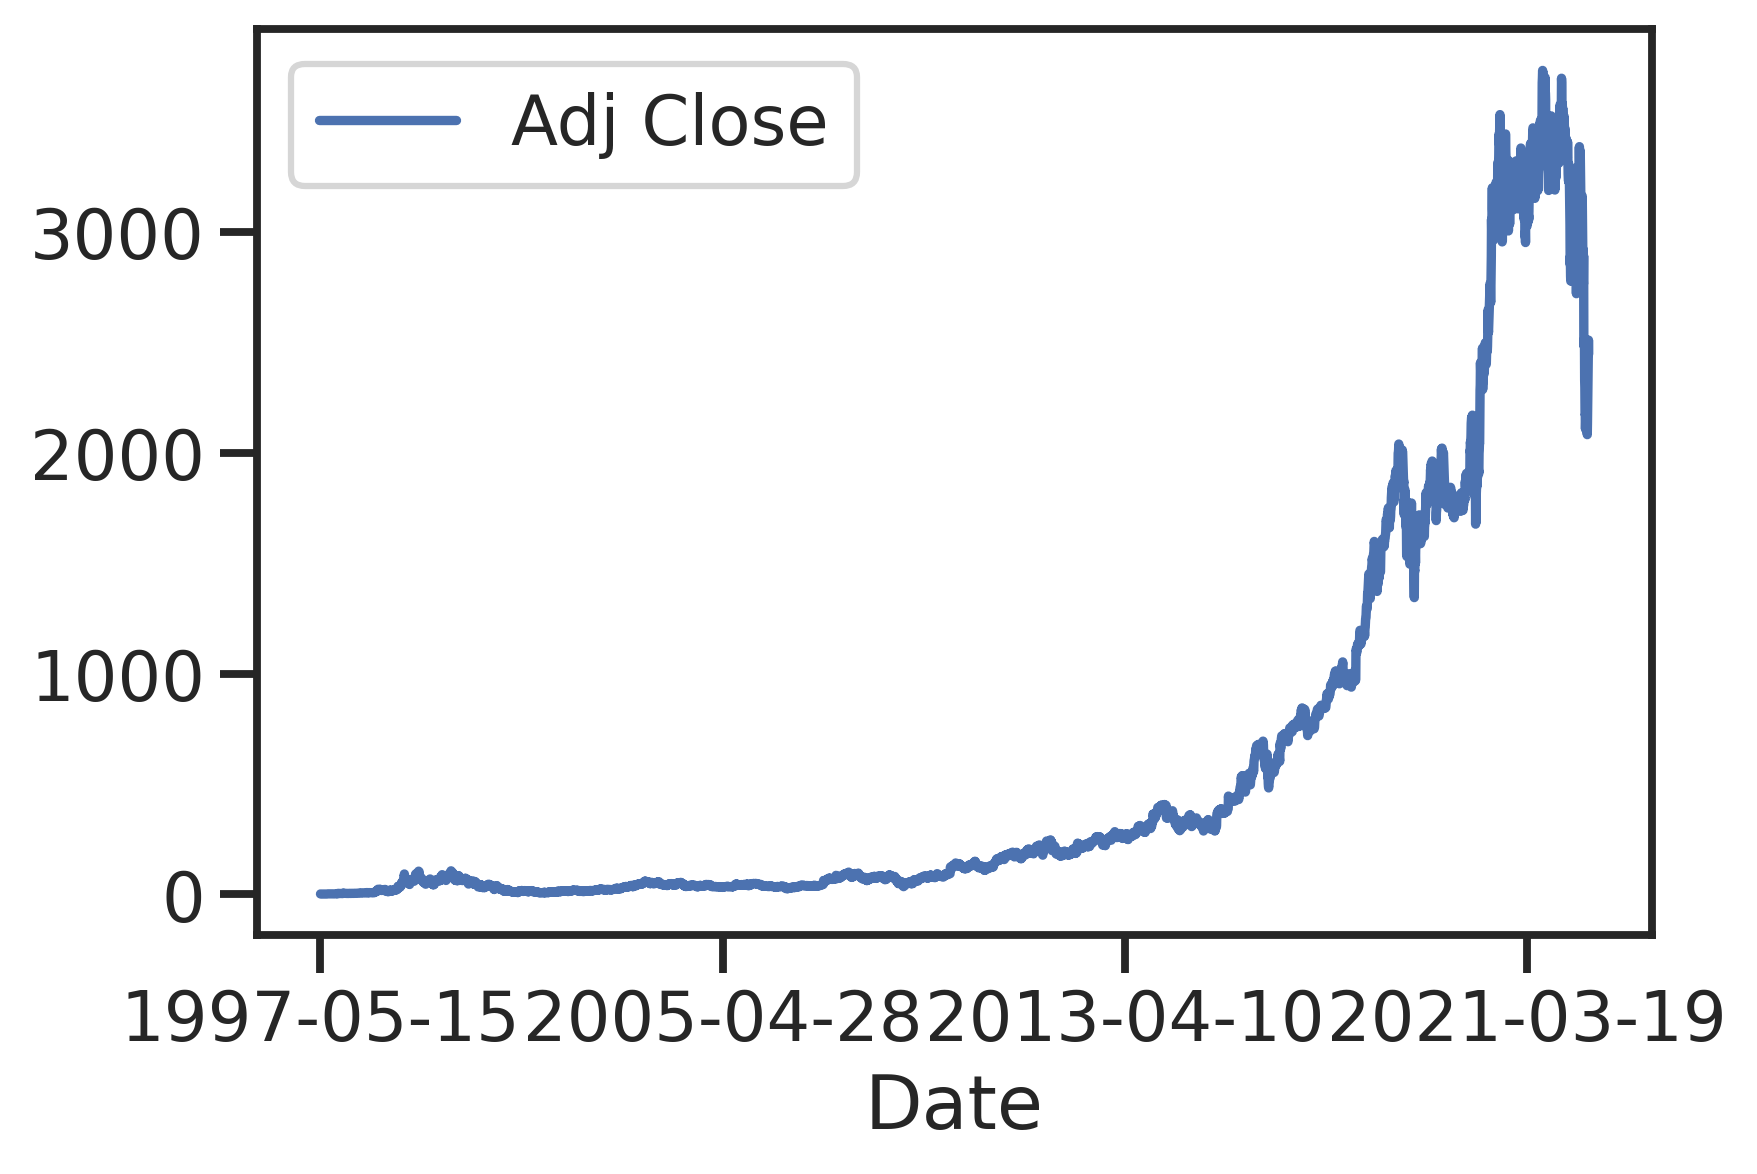

In [ ]:
df.plot()

In [ ]:
# split the data
train = df[:5000]
test = df[5000:]

## Time Series Exploration 
#### ACF Auto Correlation Stationarity

In [ ]:
# Test for stationarity 
from statsmodels.tsa.stattools import adfuller

adfullerreport = adfuller(train["Adj Close"])

adfullerreportdata = pd.DataFrame(adfullerreport[0:4],
                                  columns = ["Values"],
                                  index=["ADF F% statistics",
                                         "P-value",
                                         "No. of lags used",
                                         "No. of observations"])
adfullerreportdata

# not stationary

,Values
ADF F% statistics,3.281692
P-value,1.000000
No. of lags used,31.000000
No. of observations,4968.000000


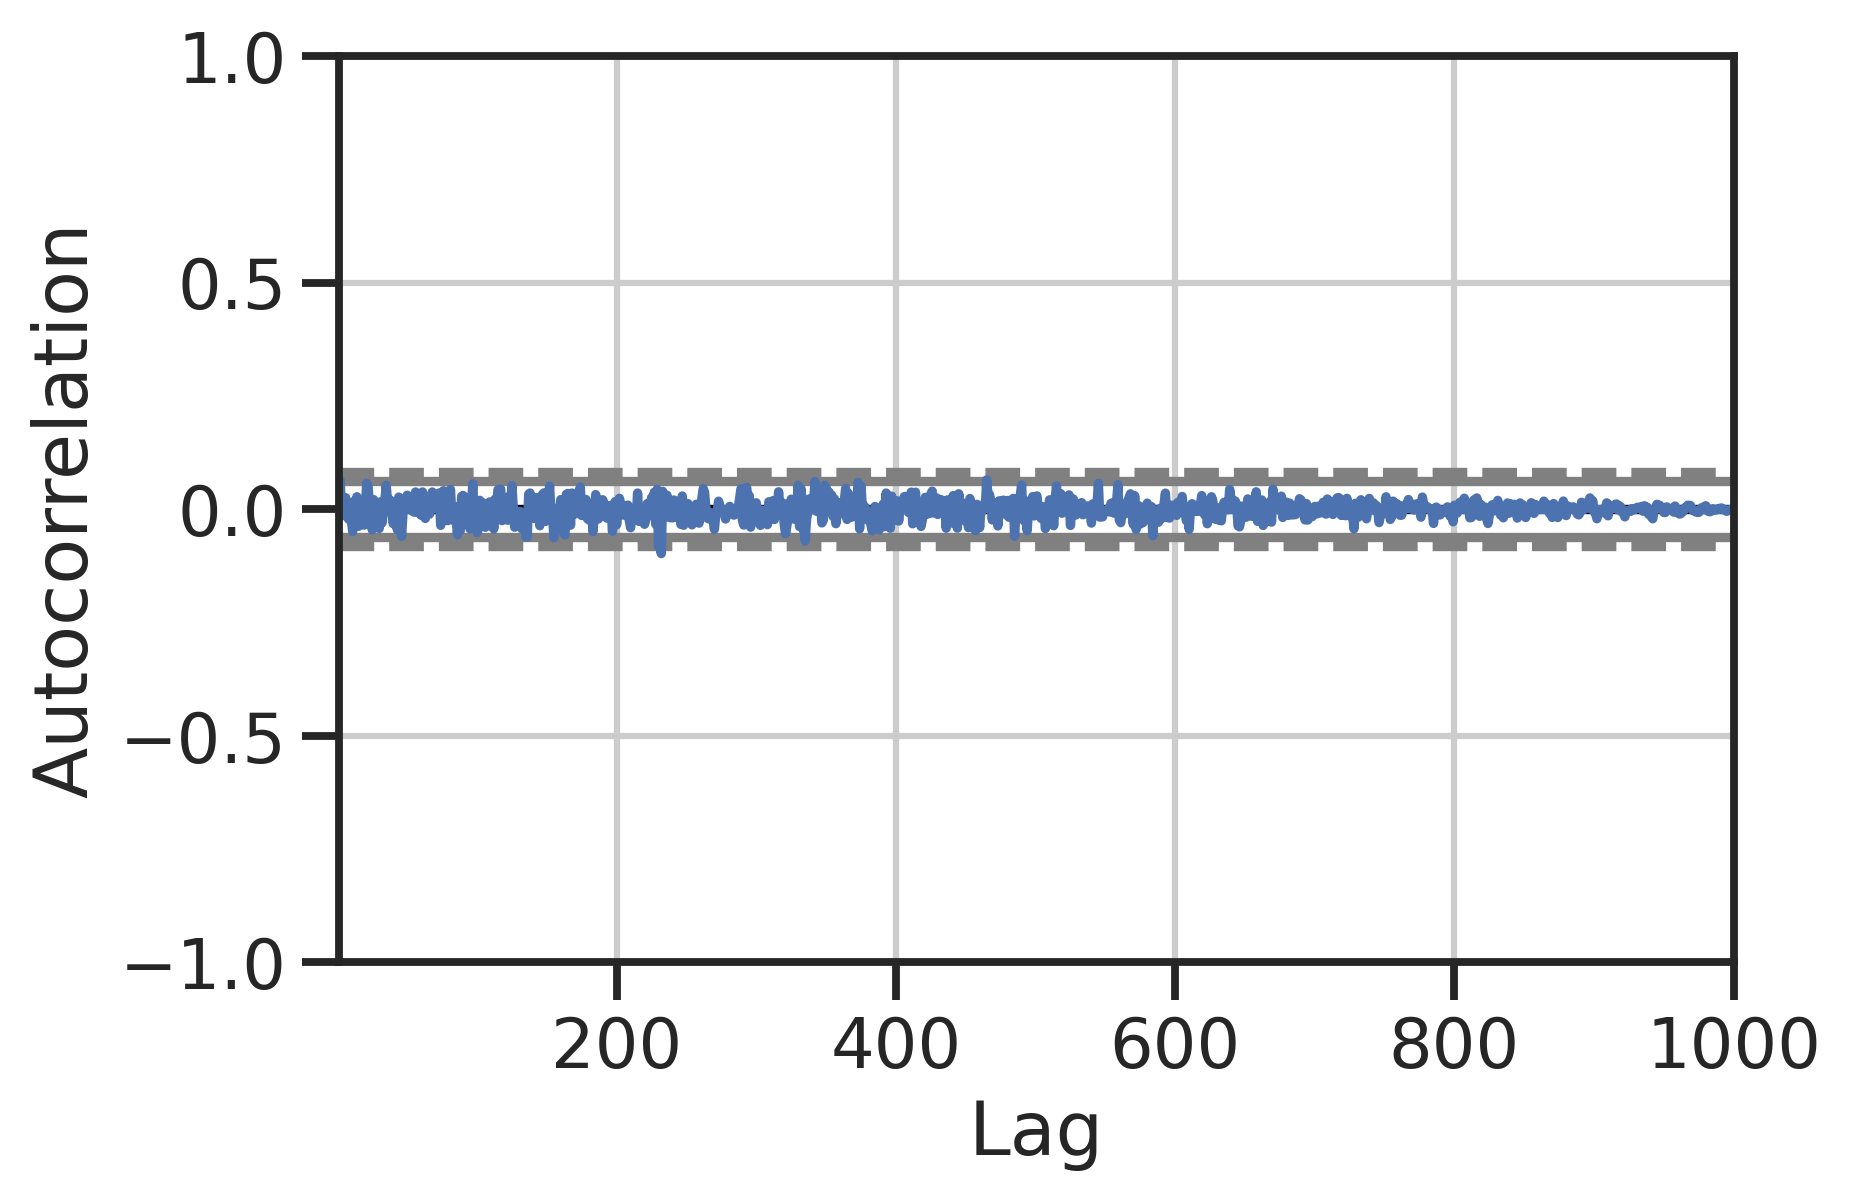

In [ ]:
# Test for White Noise - # example 

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
randval = np.random.randn(1000)
autocorrelation_plot(randval)
plt.show()

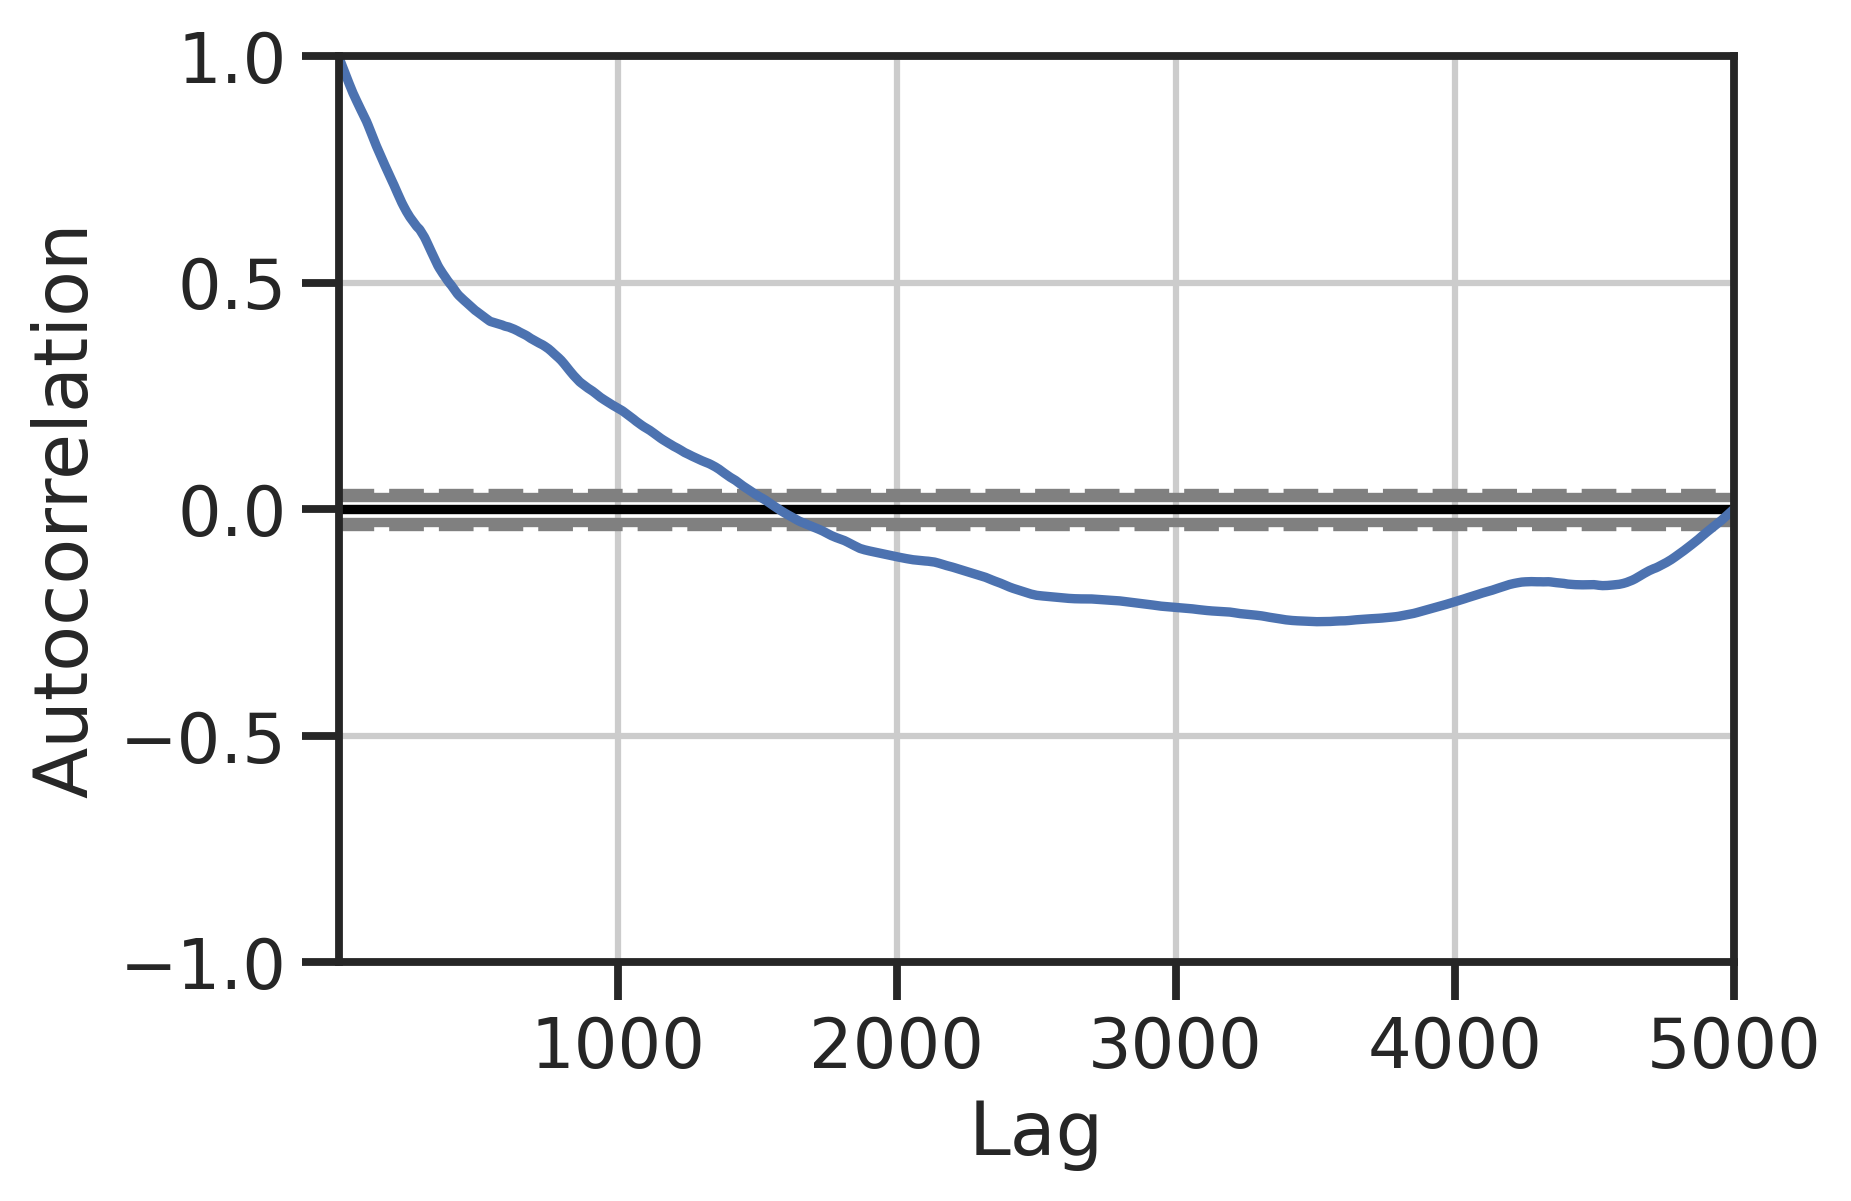

'\nfor lag 1 there is a sharp decline, and after the 500th lag the line goes lower and approaches zero. \nSince all autocorrelations are not equal to zero, we can confirm that there is no white noise.\n'

In [ ]:
autocorrelation_plot(train["Adj Close"])
plt.show()

'''
for lag 1 there is a sharp decline, and after the 500th lag the line goes lower and approaches zero. 
Since all autocorrelations are not equal to zero, we can confirm that there is no white noise.
'''

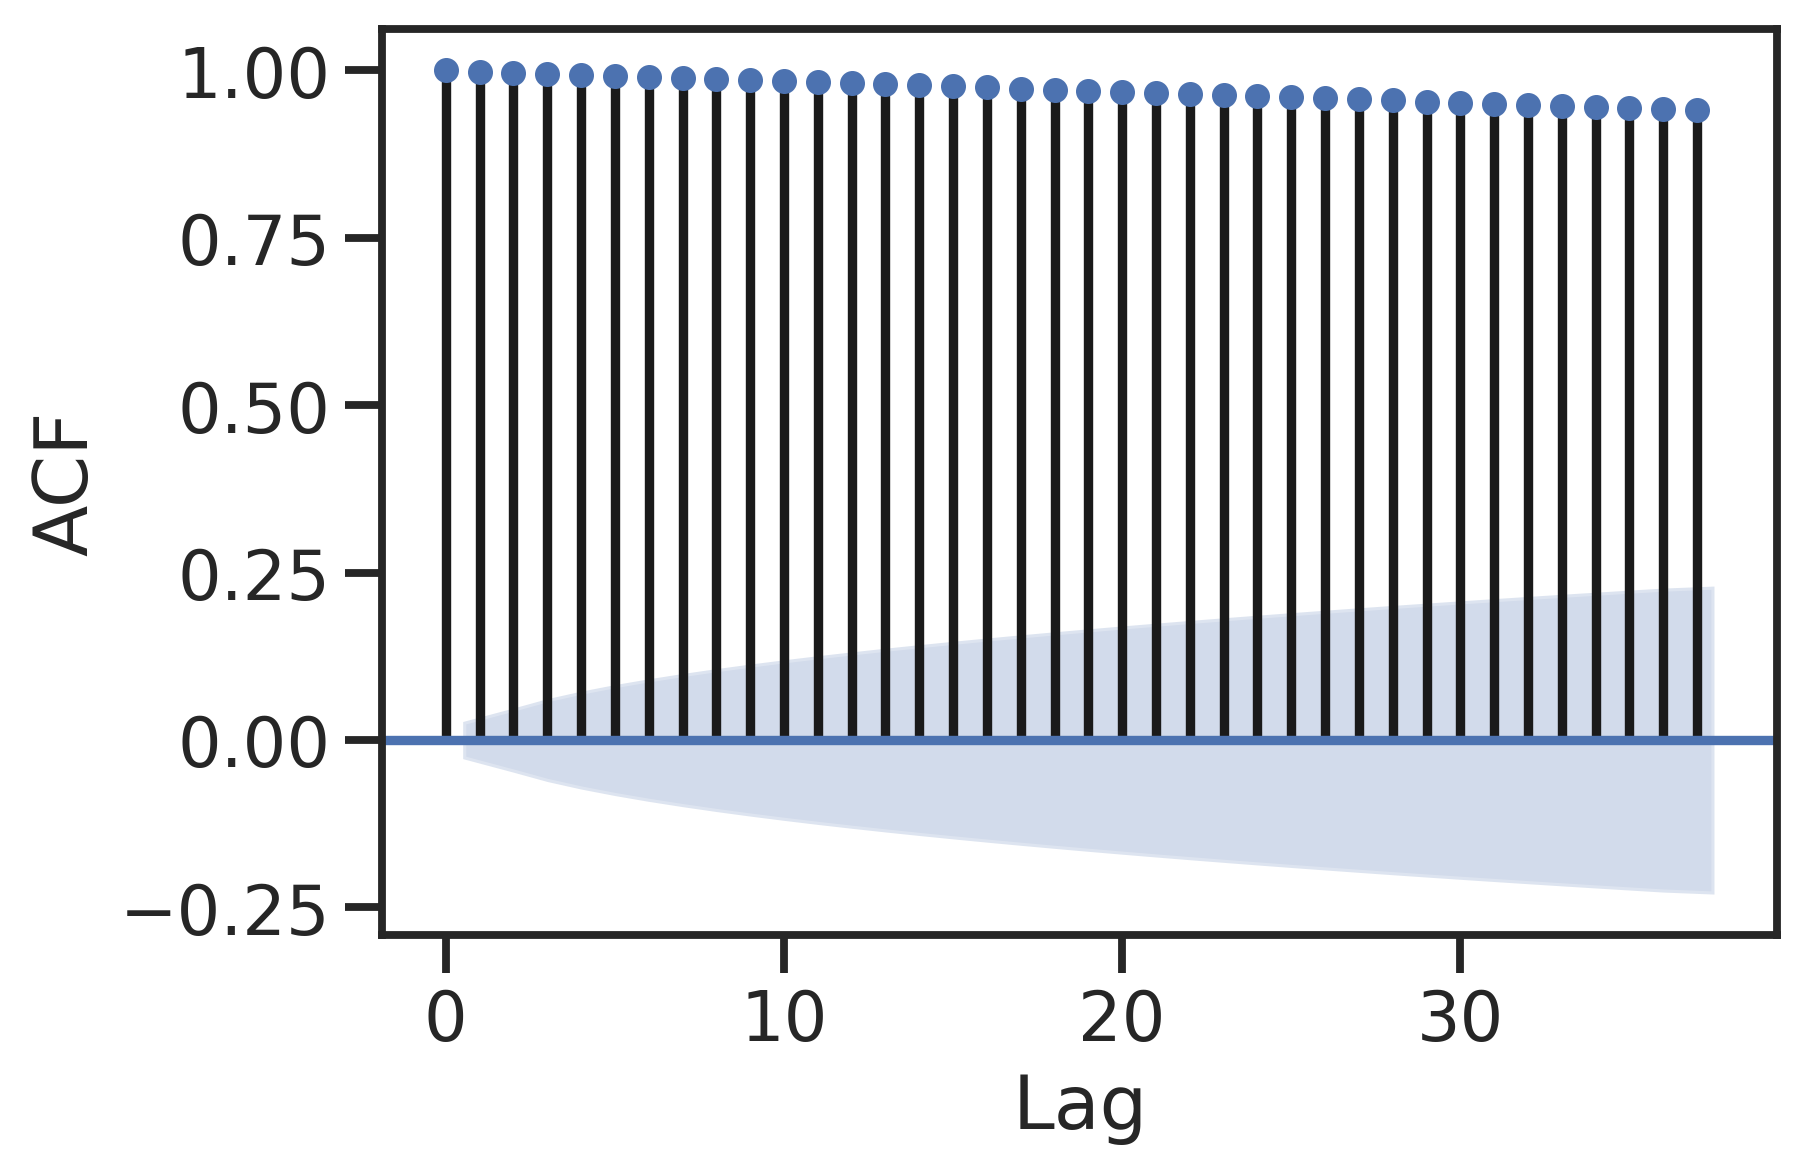

<function matplotlib.pyplot.show>

In [ ]:
# another ACF plot 

plot_acf(train["Adj Close"])
plt.title("")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()
plt.show

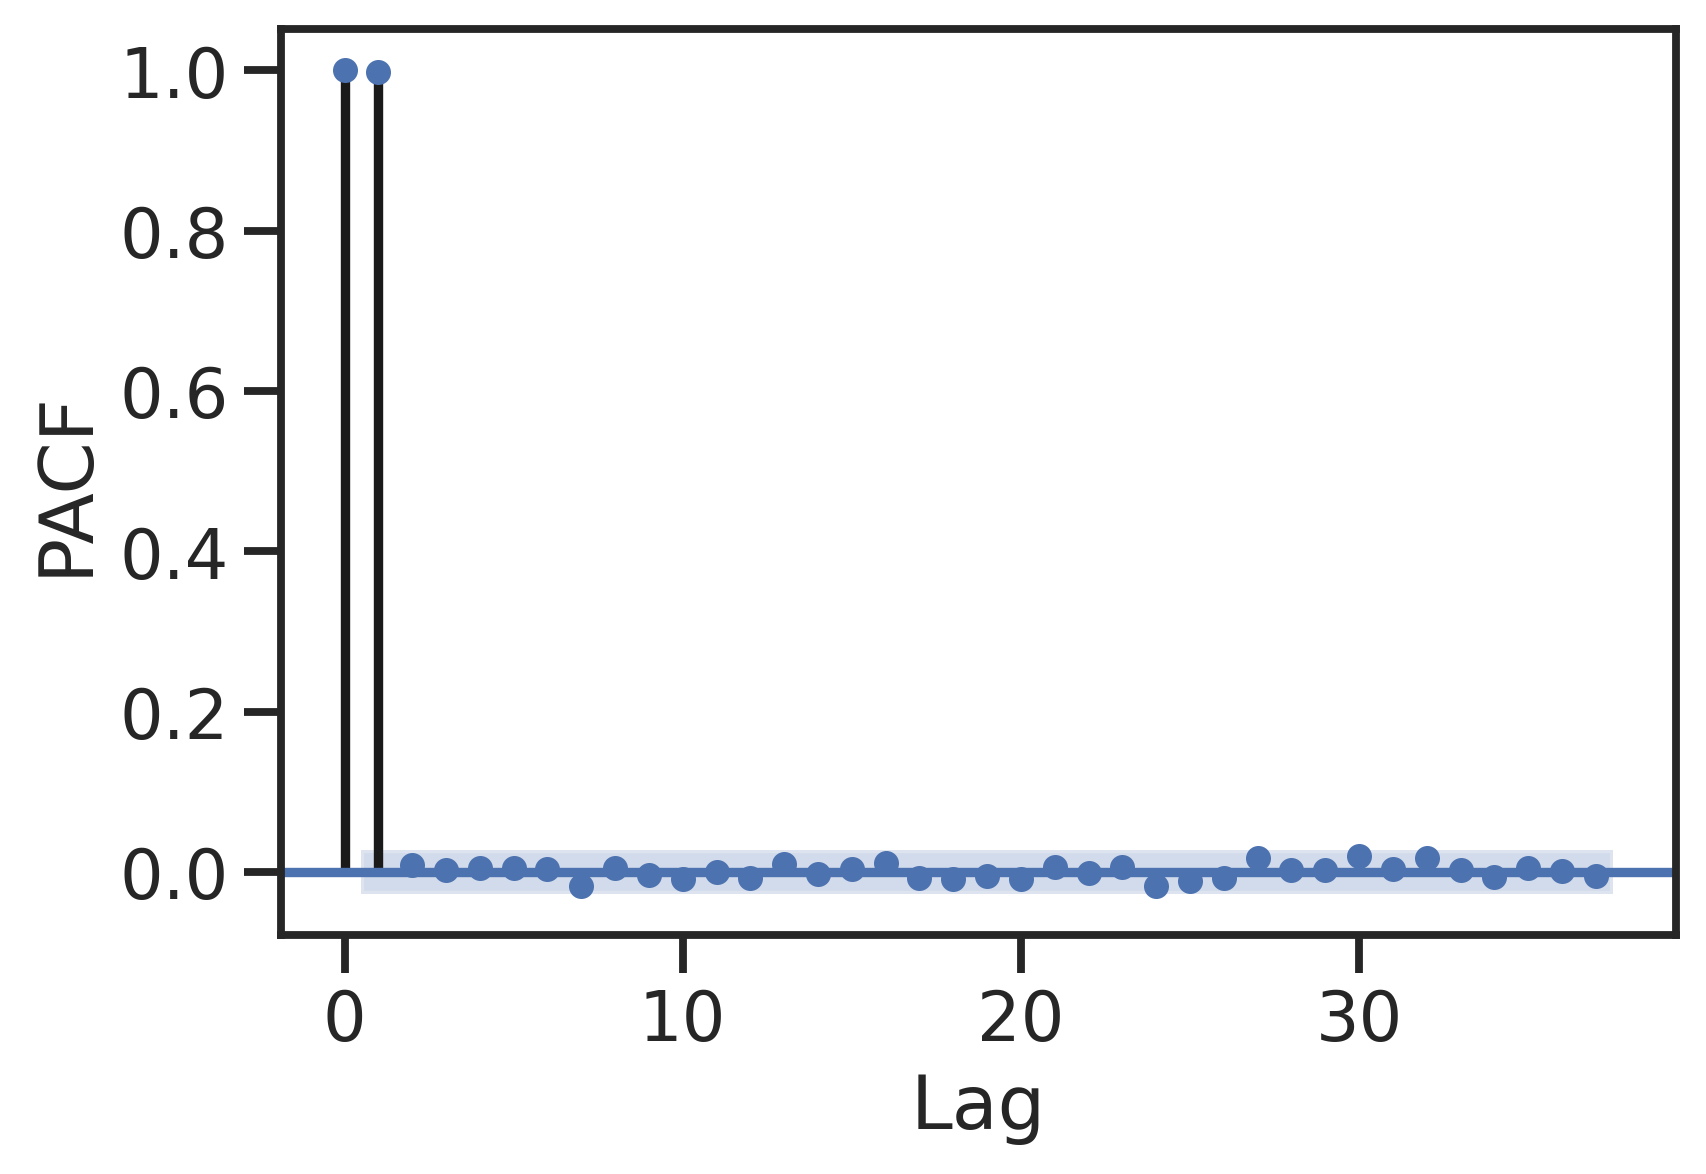

'\nThere is a significant spike in lag 1 and lag 2. \nThis means the lags can explain all higher-order autocorrelation (at most the second lag is the highest-order lag).\n'

In [ ]:
plot_pacf(train["Adj Close"])
plt.title("")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.show()

'''
There is a significant spike in lag 1 and lag 2. 
This means the lags can explain all higher-order autocorrelation (at most the second lag is the highest-order lag).
'''

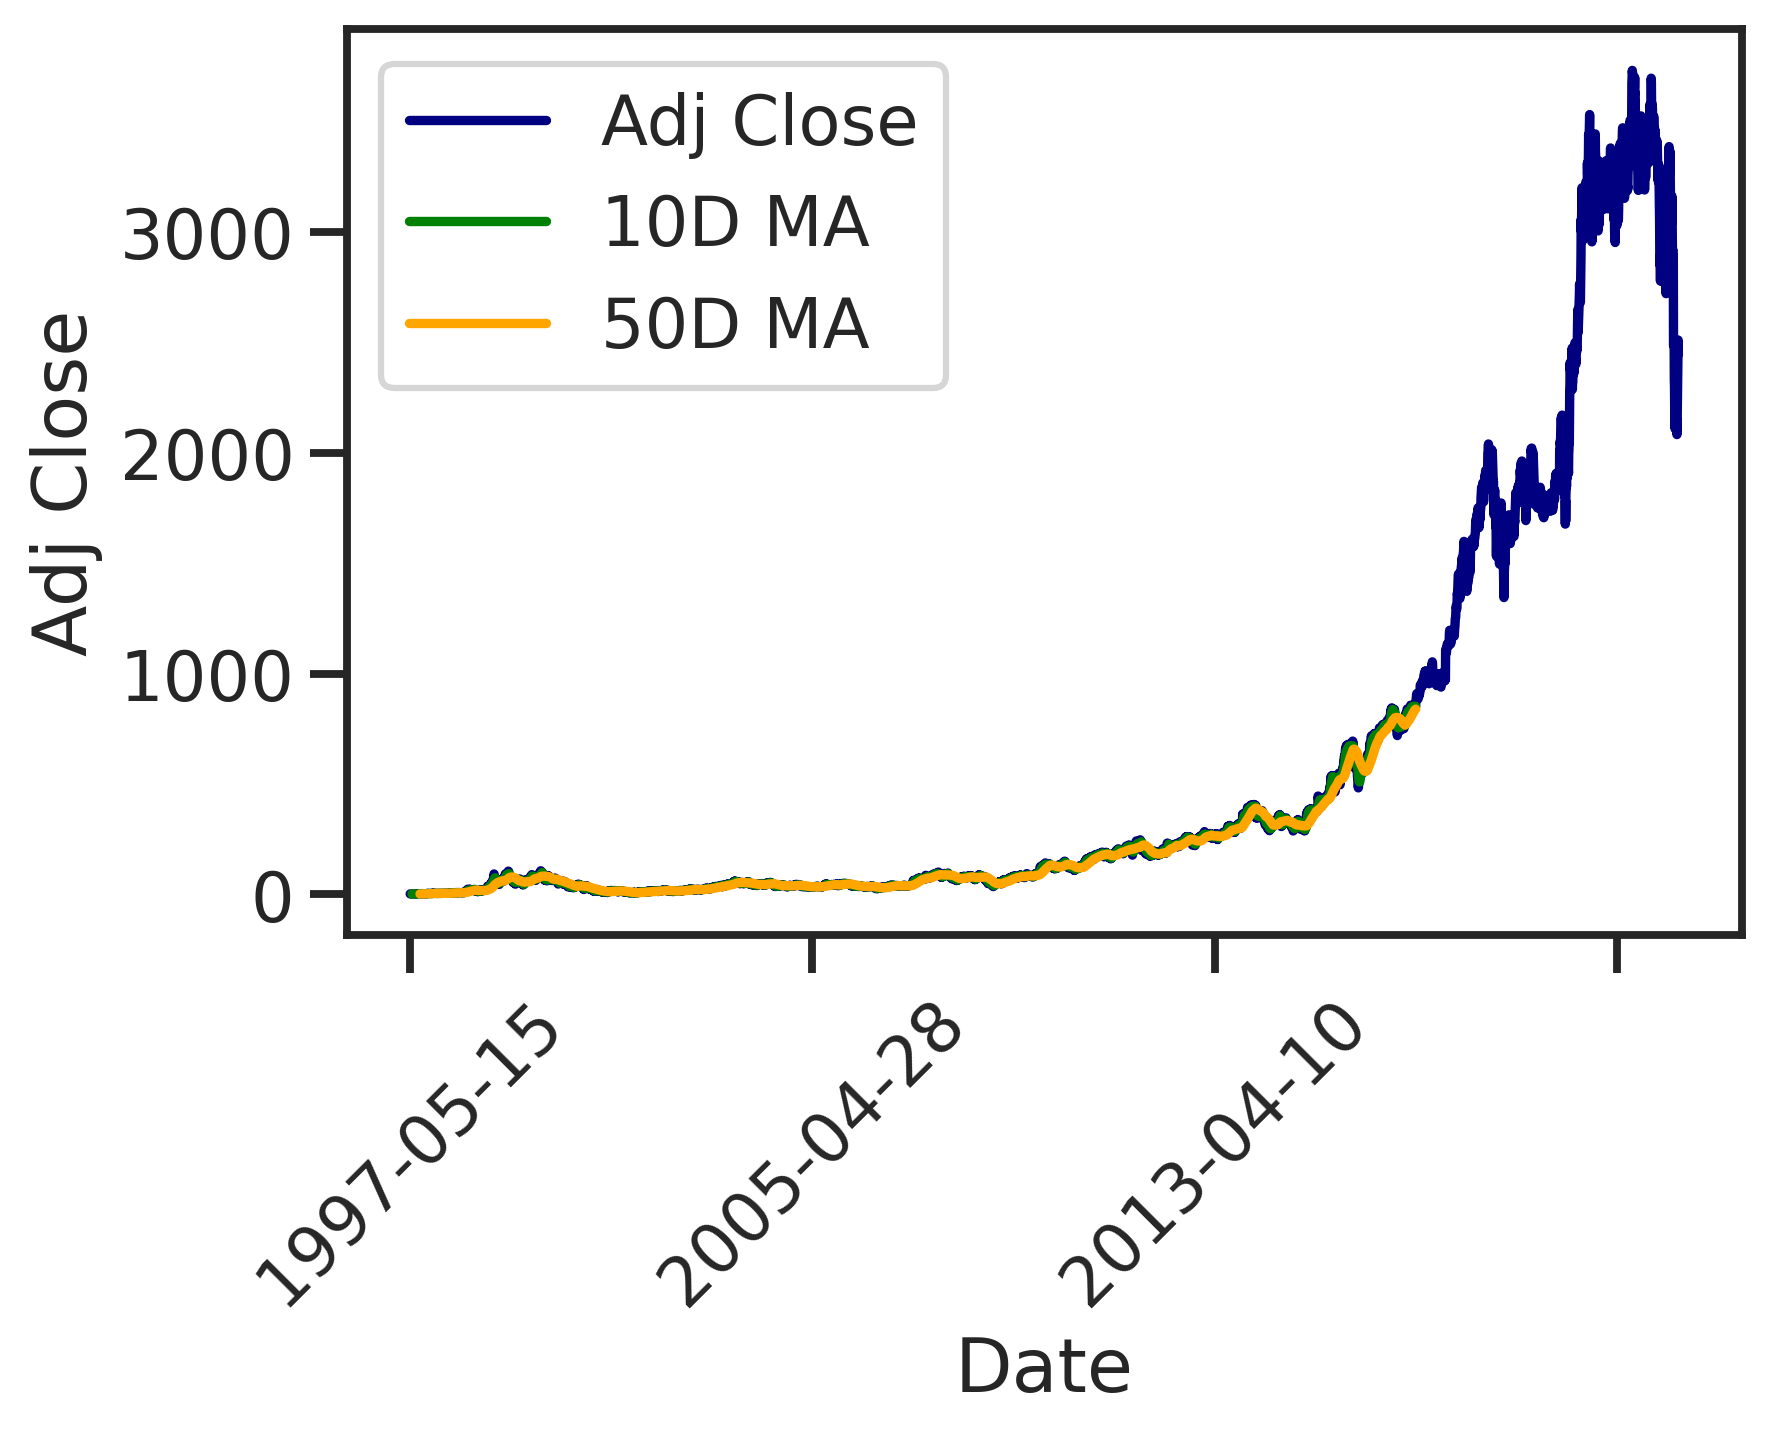

In [ ]:
# 10-day and 50-day MA Smoothening

MA10 = train["Adj Close"].rolling(window=10).mean()
MA50 = train["Adj Close"].rolling(window=50).mean()

df.plot(kind="line",color="navy")
MA10.plot(kind="line",color="green",label="10D MA")
MA50.plot(kind="line",color="orange",label="50D MA")

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Adj Close")
plt.legend()
plt.show()

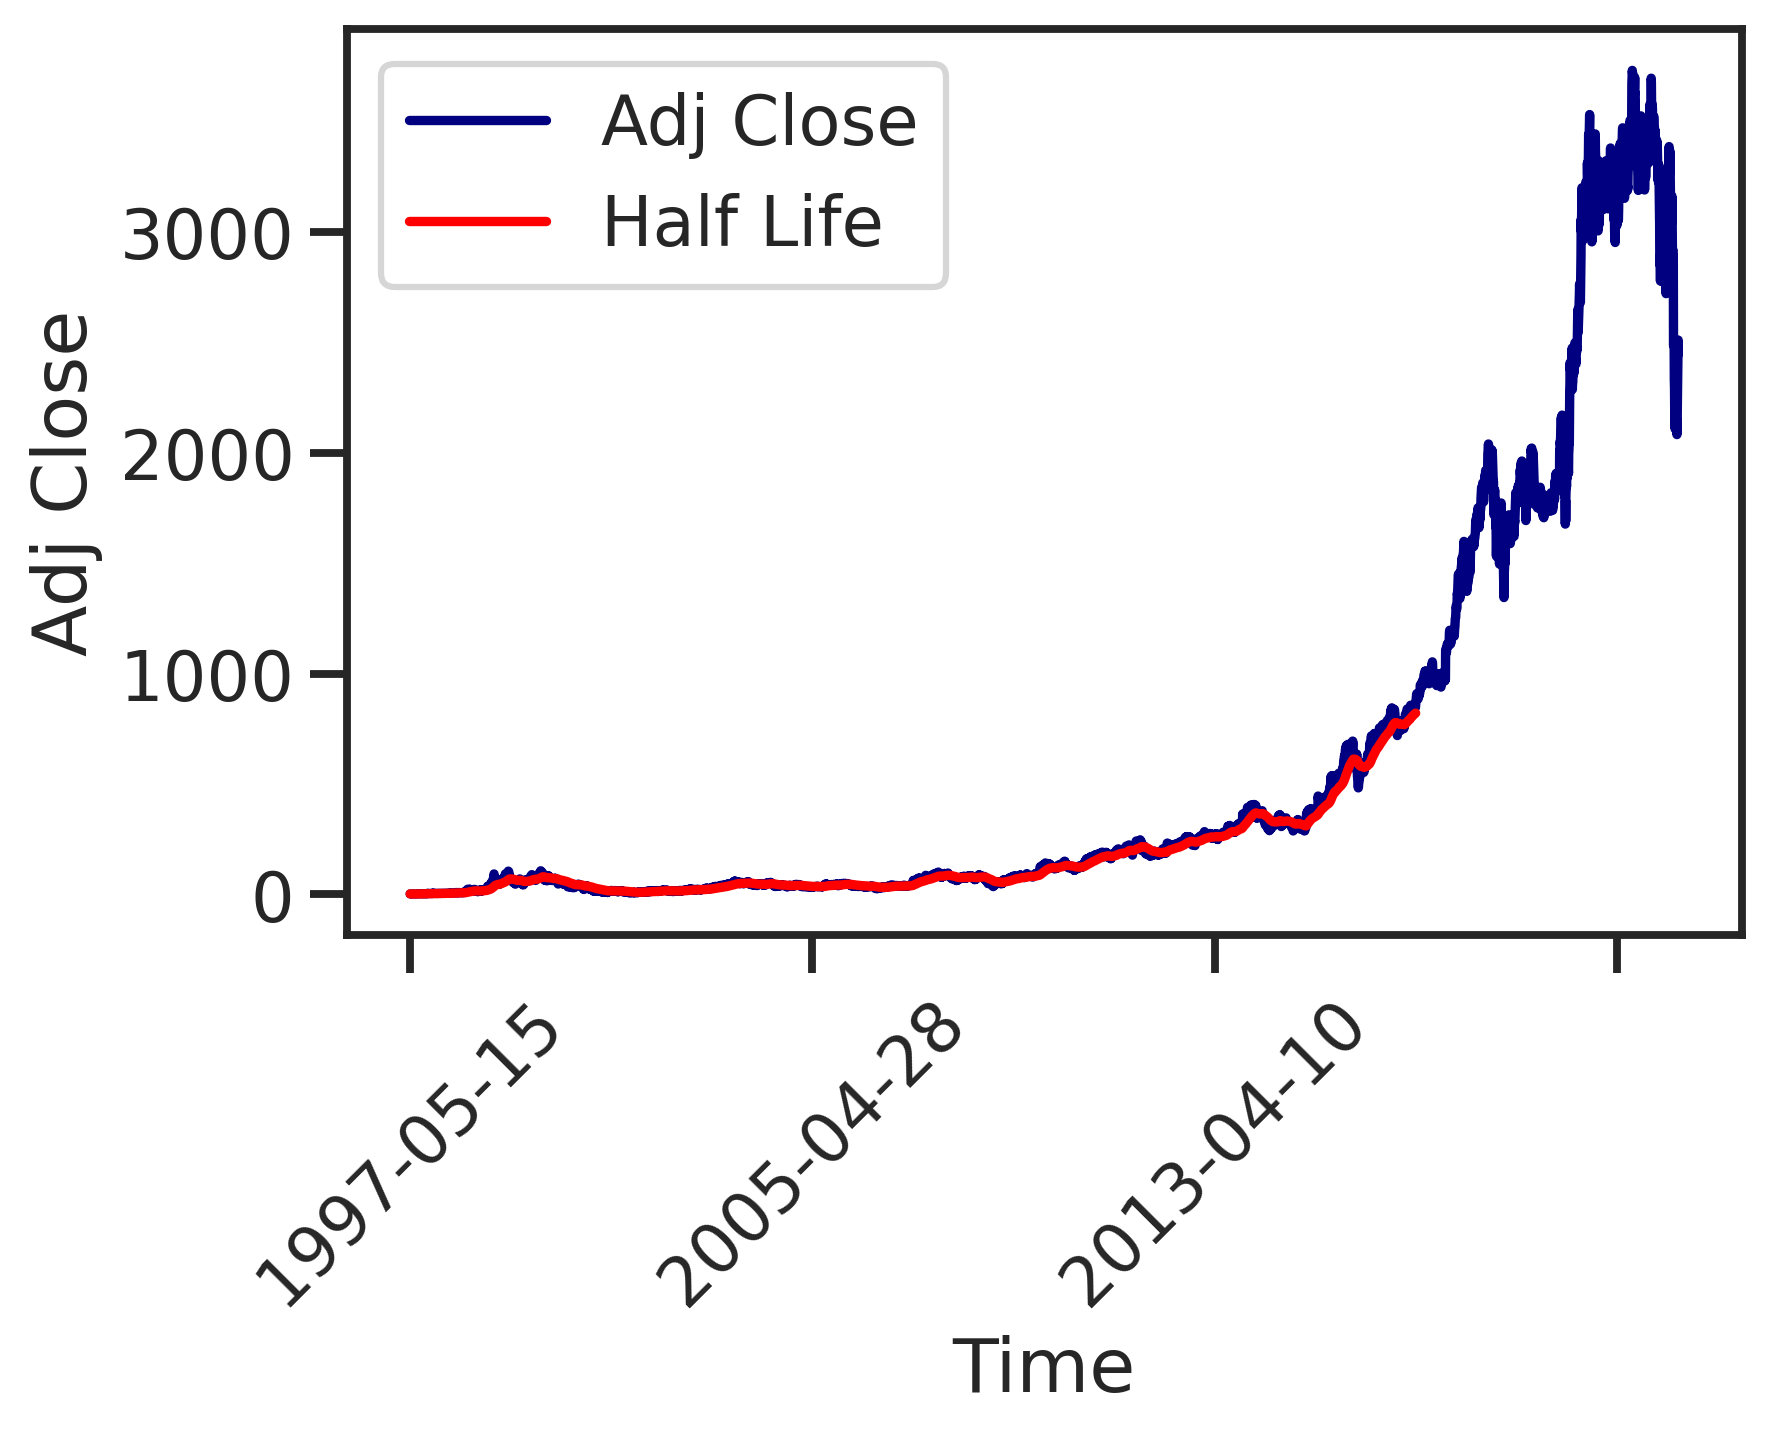

In [ ]:
# Exponential Smoothening
# The exponential smoothing method weighs values outside the window to zero...
# ...where enormous weighted values rapidly die out and minor weighted values gradually vanish

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html

Exp = train["Adj Close"].ewm(halflife=30).mean()

df.plot(kind="line", color="navy")
Exp.plot(kind="line", color="red", label="Half Life")

plt.xlabel("Time")
plt.ylabel("Adj Close")
plt.xticks(rotation=45)
plt.legend()
plt.show()

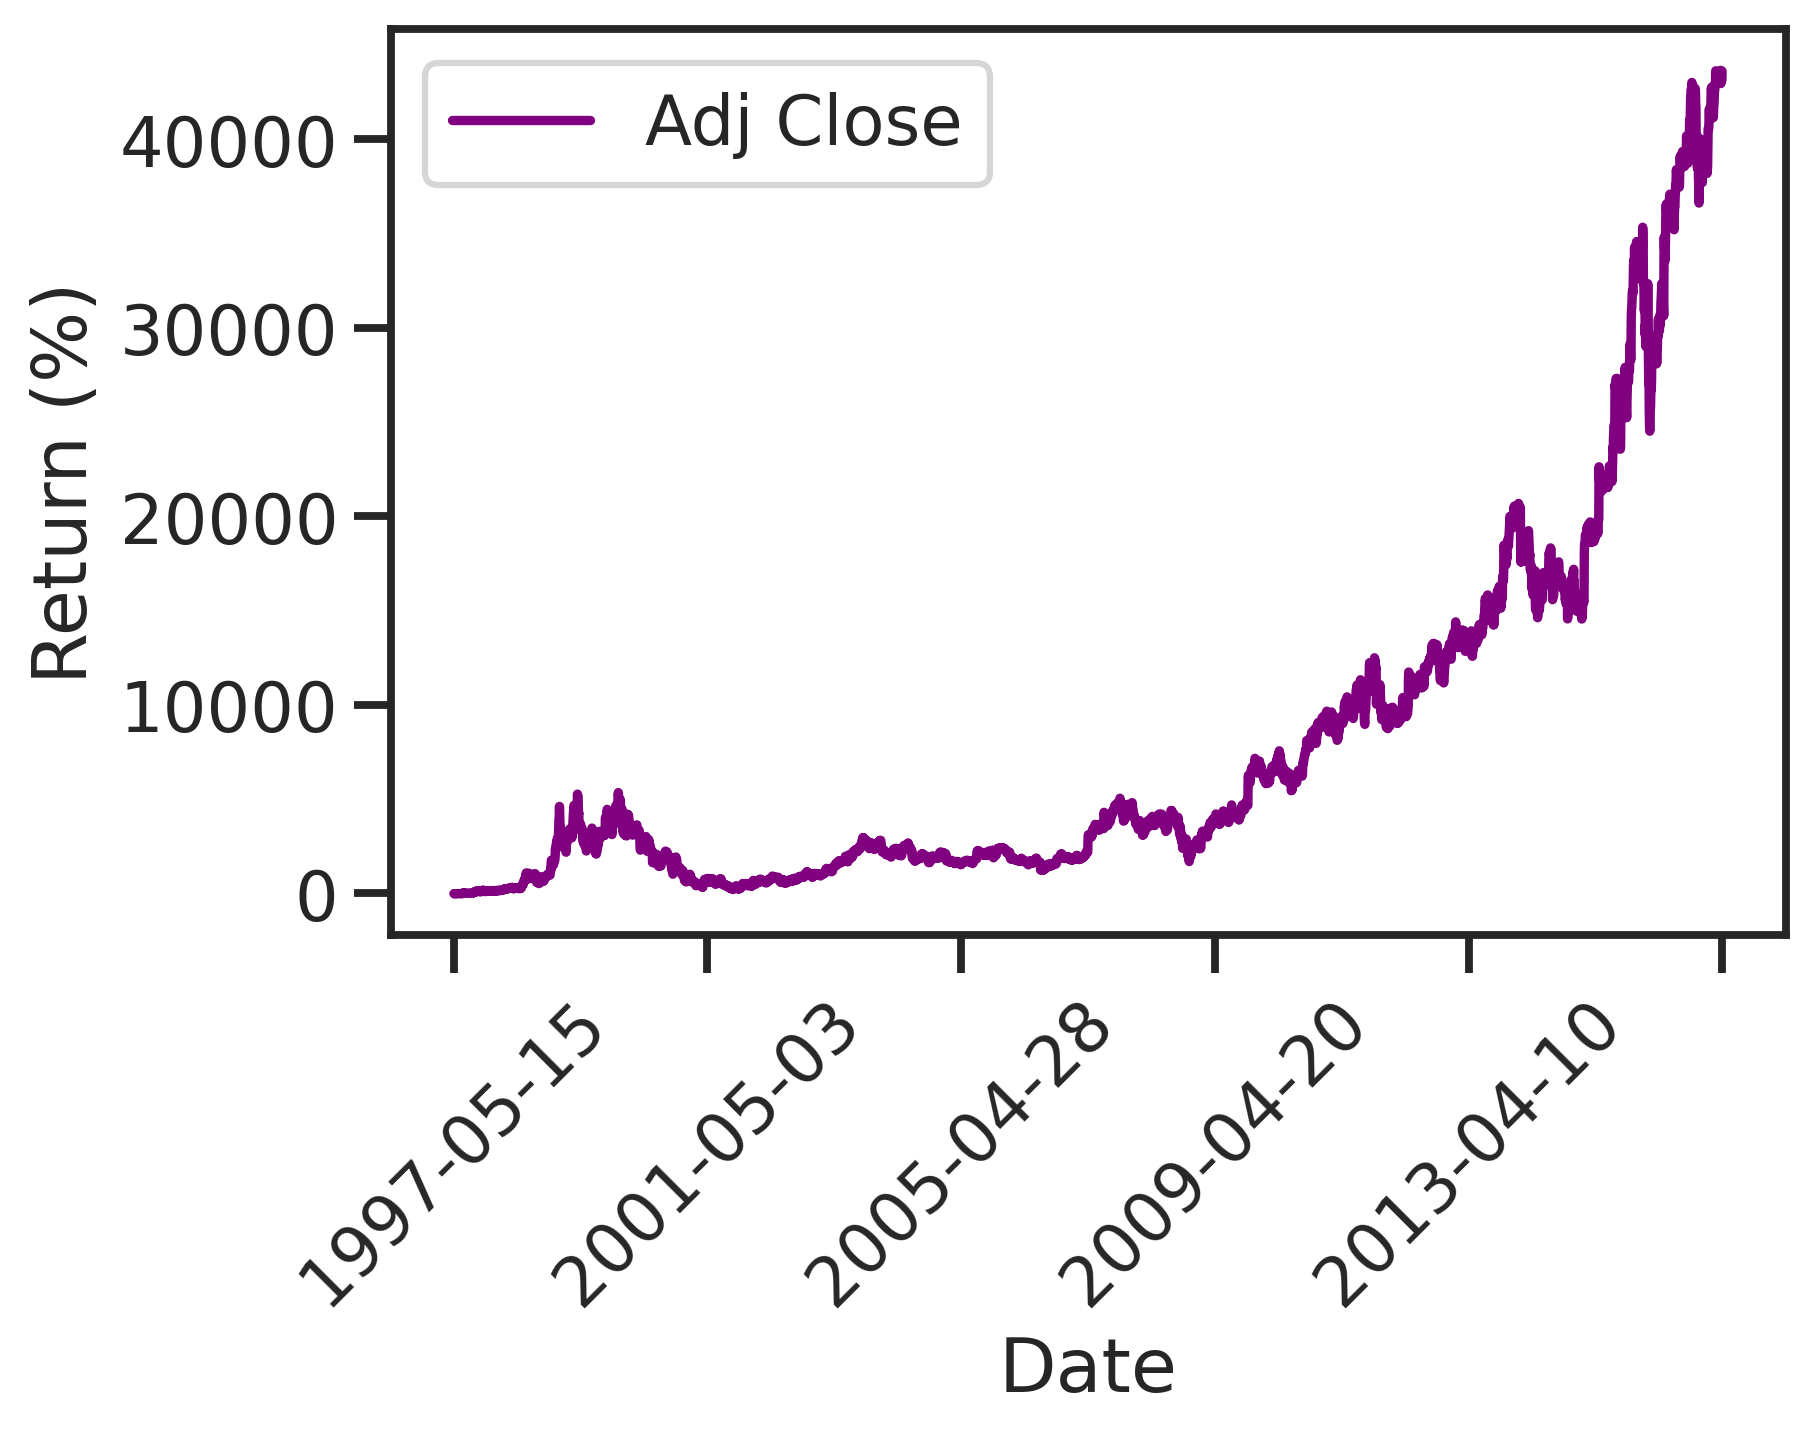

In [ ]:
# Cumulative Return - Asset Return % over teh period

pr = train.pct_change()
pr_plus_one = pr.add(1)
cumulative_return = pr_plus_one.cumprod().sub(1)

fig, ax = plt.subplots()
cumulative_return.mul(100).plot(ax=ax, color="purple")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.xticks(rotation=45)
plt.show()

## Develop ARIMA Model

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [ ]:
for param in pdq:
    mod = ARIMA(train, order=param)
    results = mod.fit()
    print('ARIMA{} AIC:{}'.format(param, results.aic))

In [ ]:
arima_model = ARIMA(train, order=(1, 1, 1))  
arima_fitted = arima_model.fit() 
arima_fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5000
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14805.572
Date:                Sun, 05 Jun 2022   AIC                          29617.145
Time:                        18:20:04   BIC                          29636.696
Sample:                             0   HQIC                         29623.997
                               - 5000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0043      0.778      0.006      0.996      -1.521       1.530
ma.L1          0.0043      0.777      0.006      0.996      -1.519       1.528
sigma2        21.8861      0.113    194.445      0.000      21.666      22.107
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            186253.74
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              11.21   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


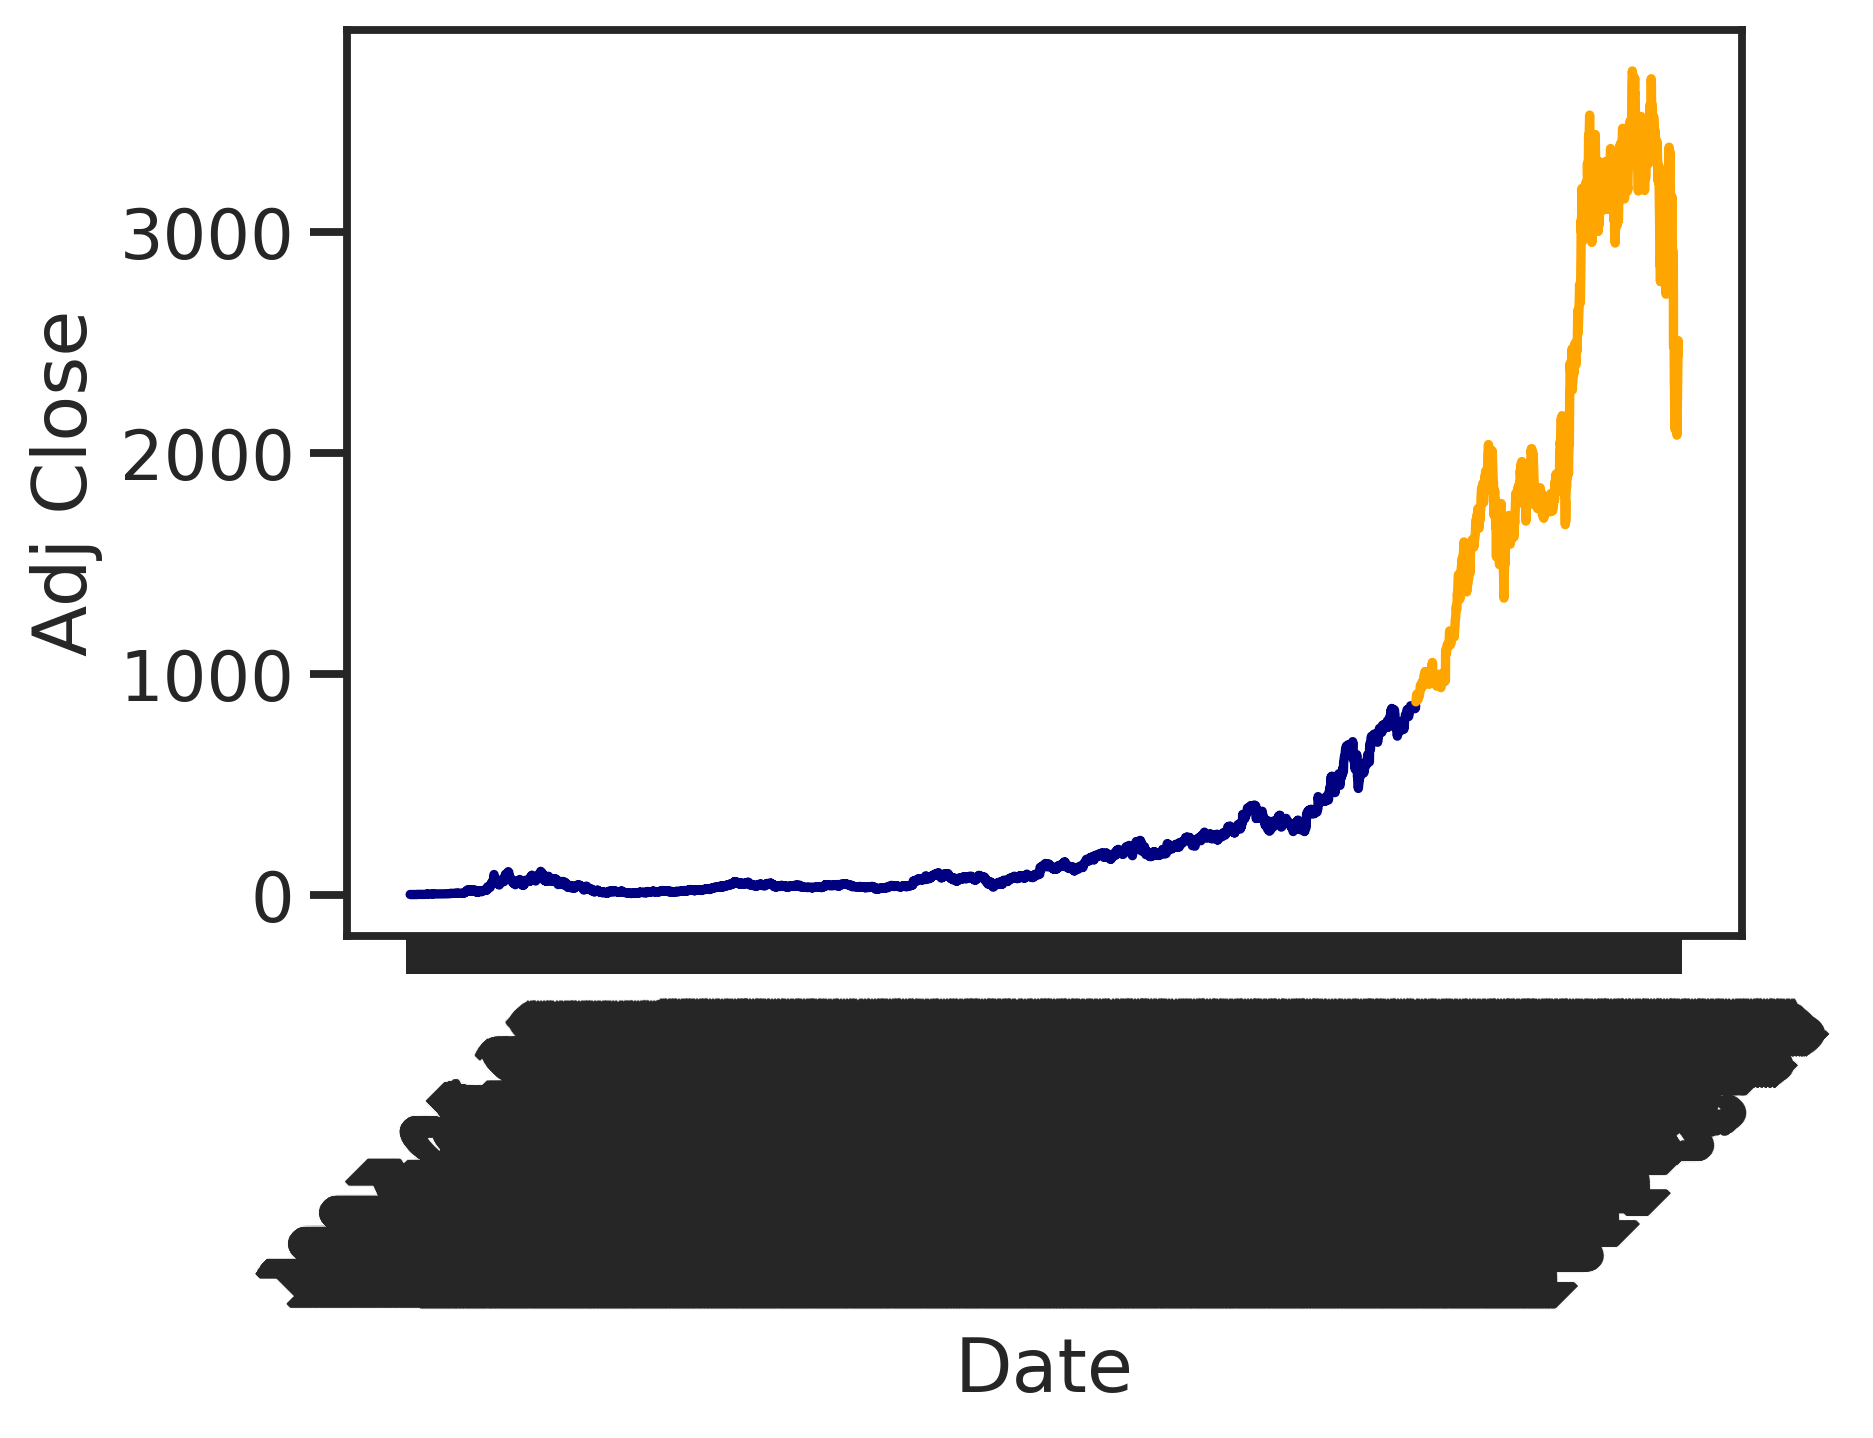

In [ ]:
fc = arima_fitted.forecast(steps=1306)

fc_series = pd.Series(fc, index=test.index)

#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

plt.plot(train, label="Training",color="navy")
plt.plot(test, label="Actual",color="orange")
plt.plot(fc_series, label="Forecast",color="black")

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

## Develop SARIMA Model

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm

sarimax_model = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5000
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -15212.776
Date:                Sun, 05 Jun 2022   AIC                          30437.552
Time:                        18:40:31   BIC                          30476.652
Sample:                             0   HQIC                         30451.256
                               - 5000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8125      0.005   -150.089      0.000      -0.823      -0.802
ar.L2         -0.6389      0.008    -81.471      0.000      -0.654      -0.624
ar.L3         -0.5035      0.009    -56.643      0.000      -0.521      -0.486
ar.L4         -0.3624      0.008    -43.650      0.000      -0.379      -0.346
ar.L5         -0.1712      0.006    -28.754      0.000      -0.183      -0.160
sigma2        25.7761      0.149    173.557      0.000      25.485      26.067
===================================================================================
Ljung-Box (L1) (Q):                   3.30   Jarque-Bera (JB):            138048.85
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):              10.95   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
n_periods = 24
fitted, confint = sarimax_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


In [ ]:
plt.plot(train, label="Training",color="navy")
plt.plot(test, label="Actual",color="orange")
plt.plot(fitted_series, label="Forecast",color="red")

#plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

## Prophet Model

In [ ]:
df = df.reset_index()
df["ds"] = df["Date"]
df["y"] = df["Adj Close"]
df.set_index("Date")

,Adj Close,ds,y
Date,,,
1997-05-15,1.958333,1997-05-15,1.958333
1997-05-16,1.729167,1997-05-16,1.729167
1997-05-19,1.708333,1997-05-19,1.708333
1997-05-20,1.635417,1997-05-20,1.635417
1997-05-21,1.427083,1997-05-21,1.427083
...,...,...,...
2022-05-27,2302.929932,2022-05-27,2302.929932
2022-05-31,2404.189941,2022-05-31,2404.189941
2022-06-01,2433.679932,2022-06-01,2433.679932


In [ ]:
df.head()

,Date,Adj Close,ds,y
0,1997-05-15,1.958333,1997-05-15,1.958333
1,1997-05-16,1.729167,1997-05-16,1.729167
2,1997-05-19,1.708333,1997-05-19,1.708333
3,1997-05-20,1.635417,1997-05-20,1.635417
4,1997-05-21,1.427083,1997-05-21,1.427083


In [ ]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95,
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                changepoint_prior_scale=0.095)

In [ ]:
model.fit(df)

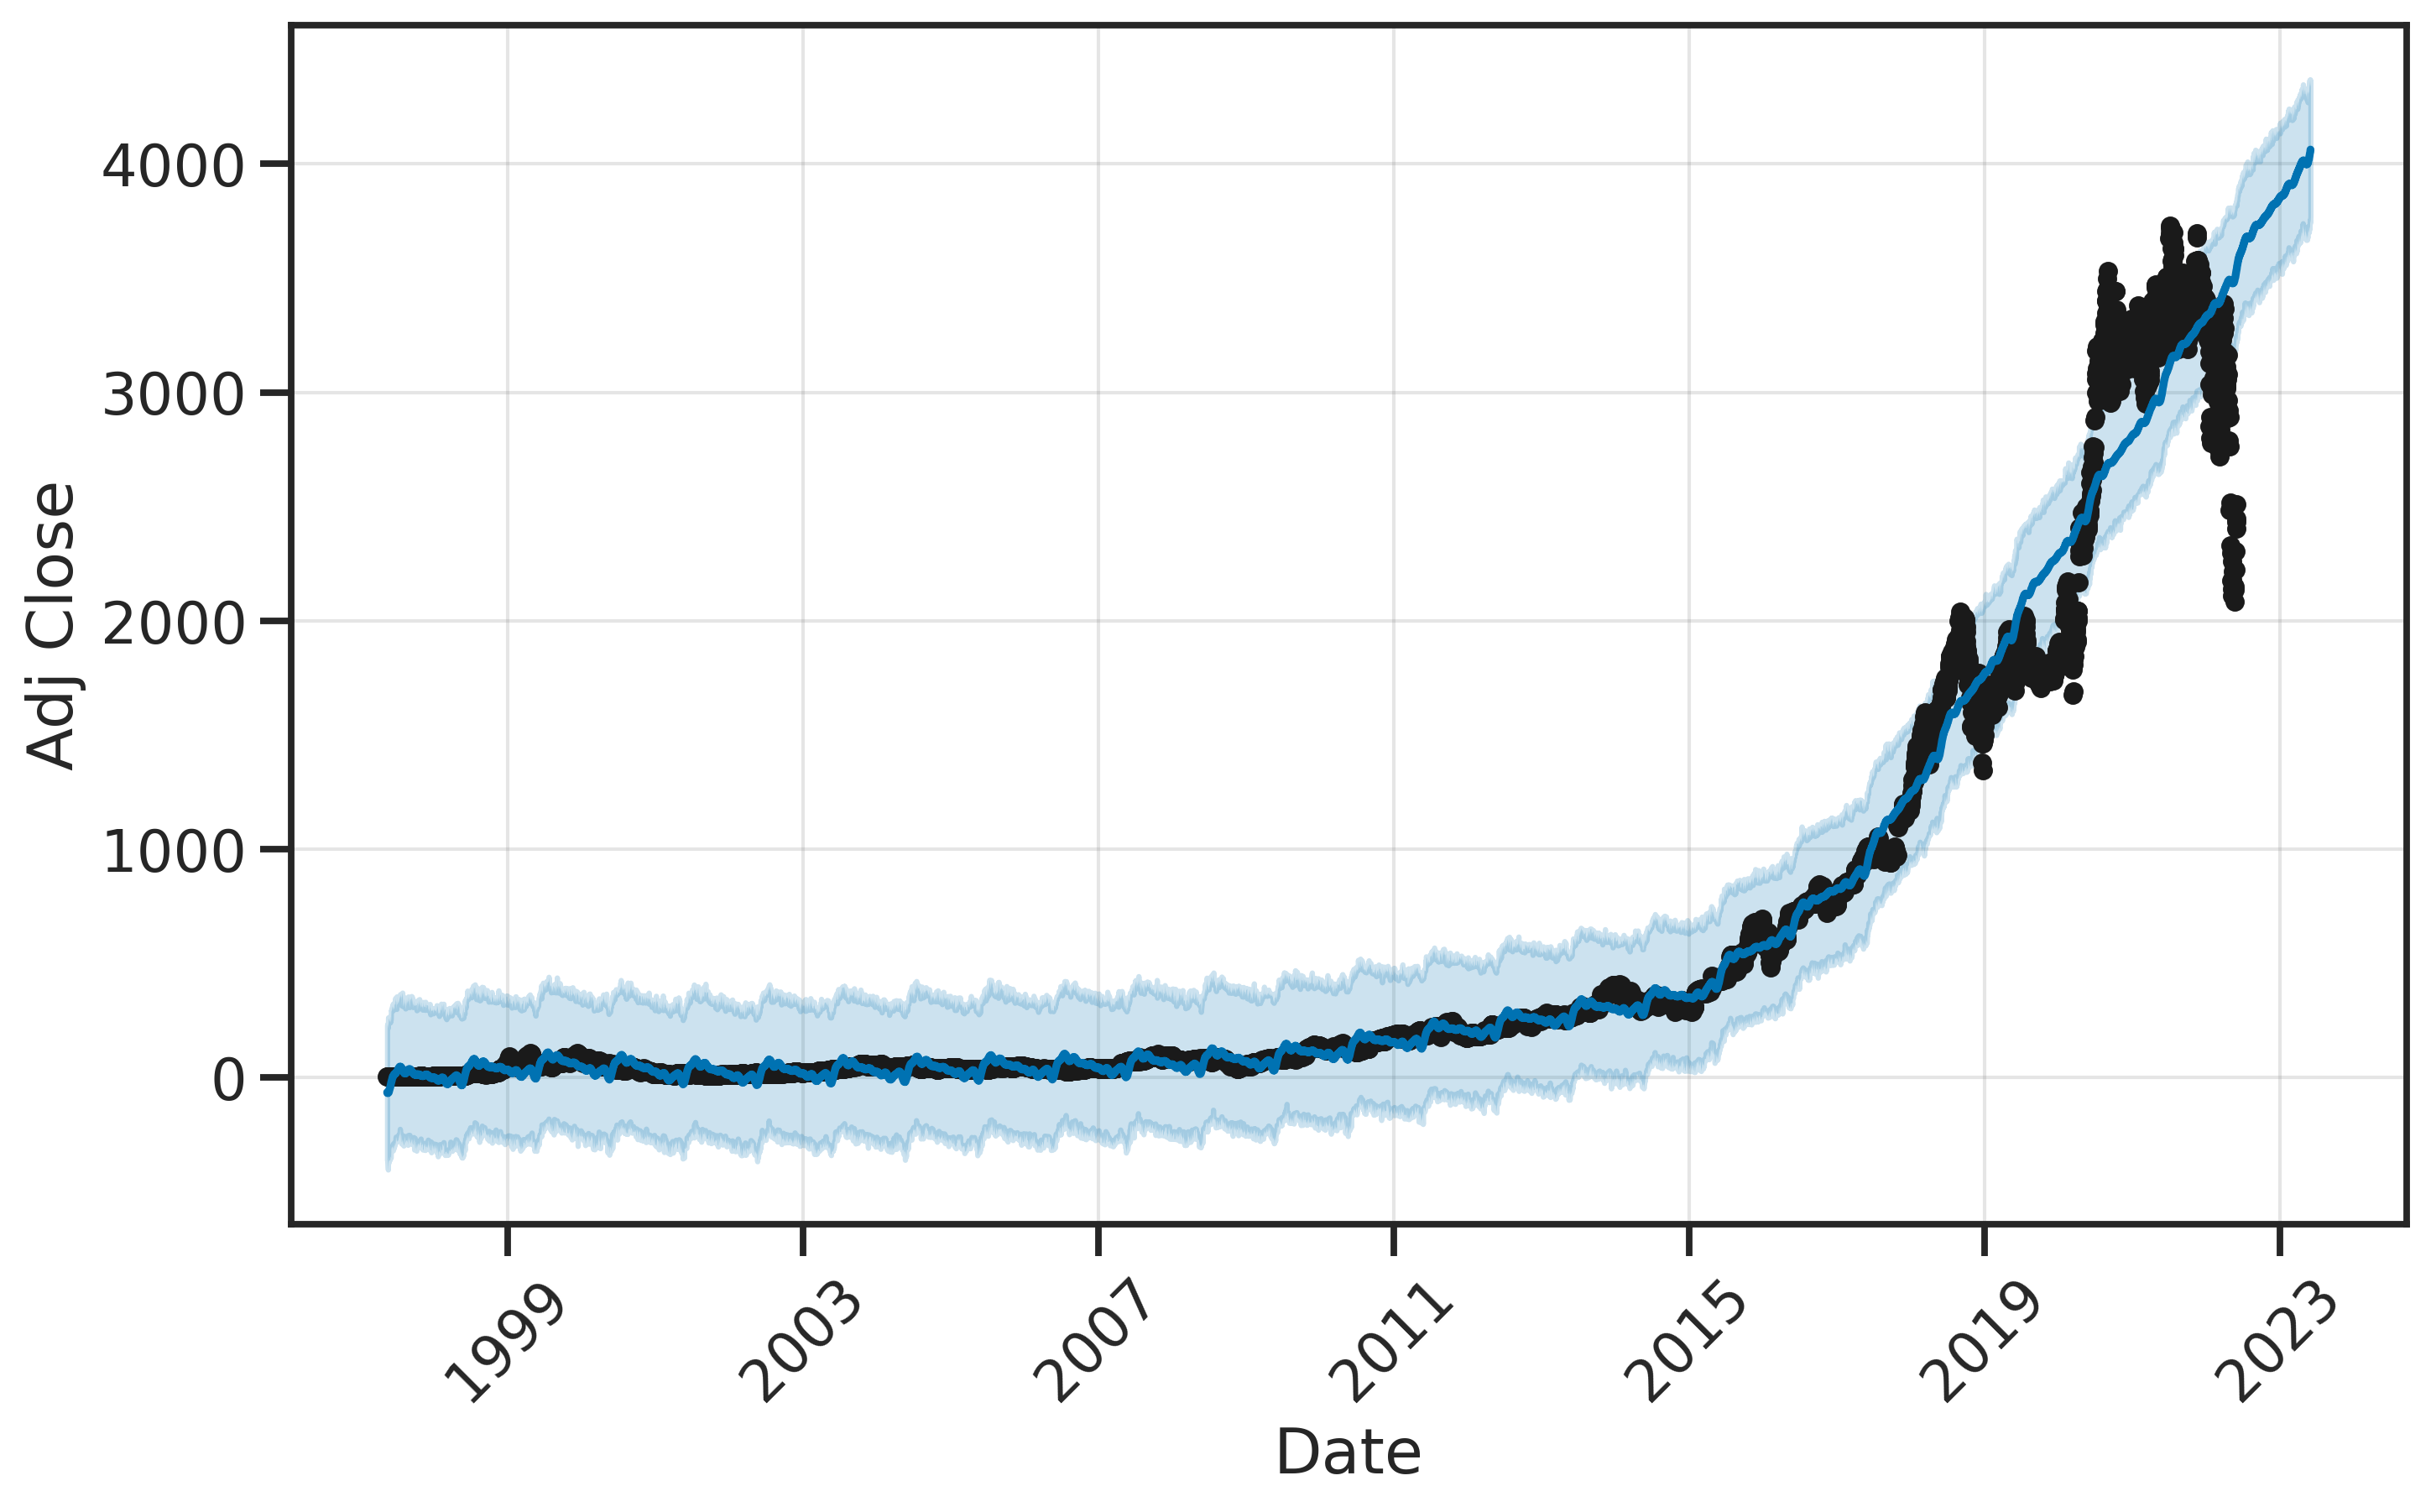

In [ ]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.xticks(rotation=45)
plt.show()

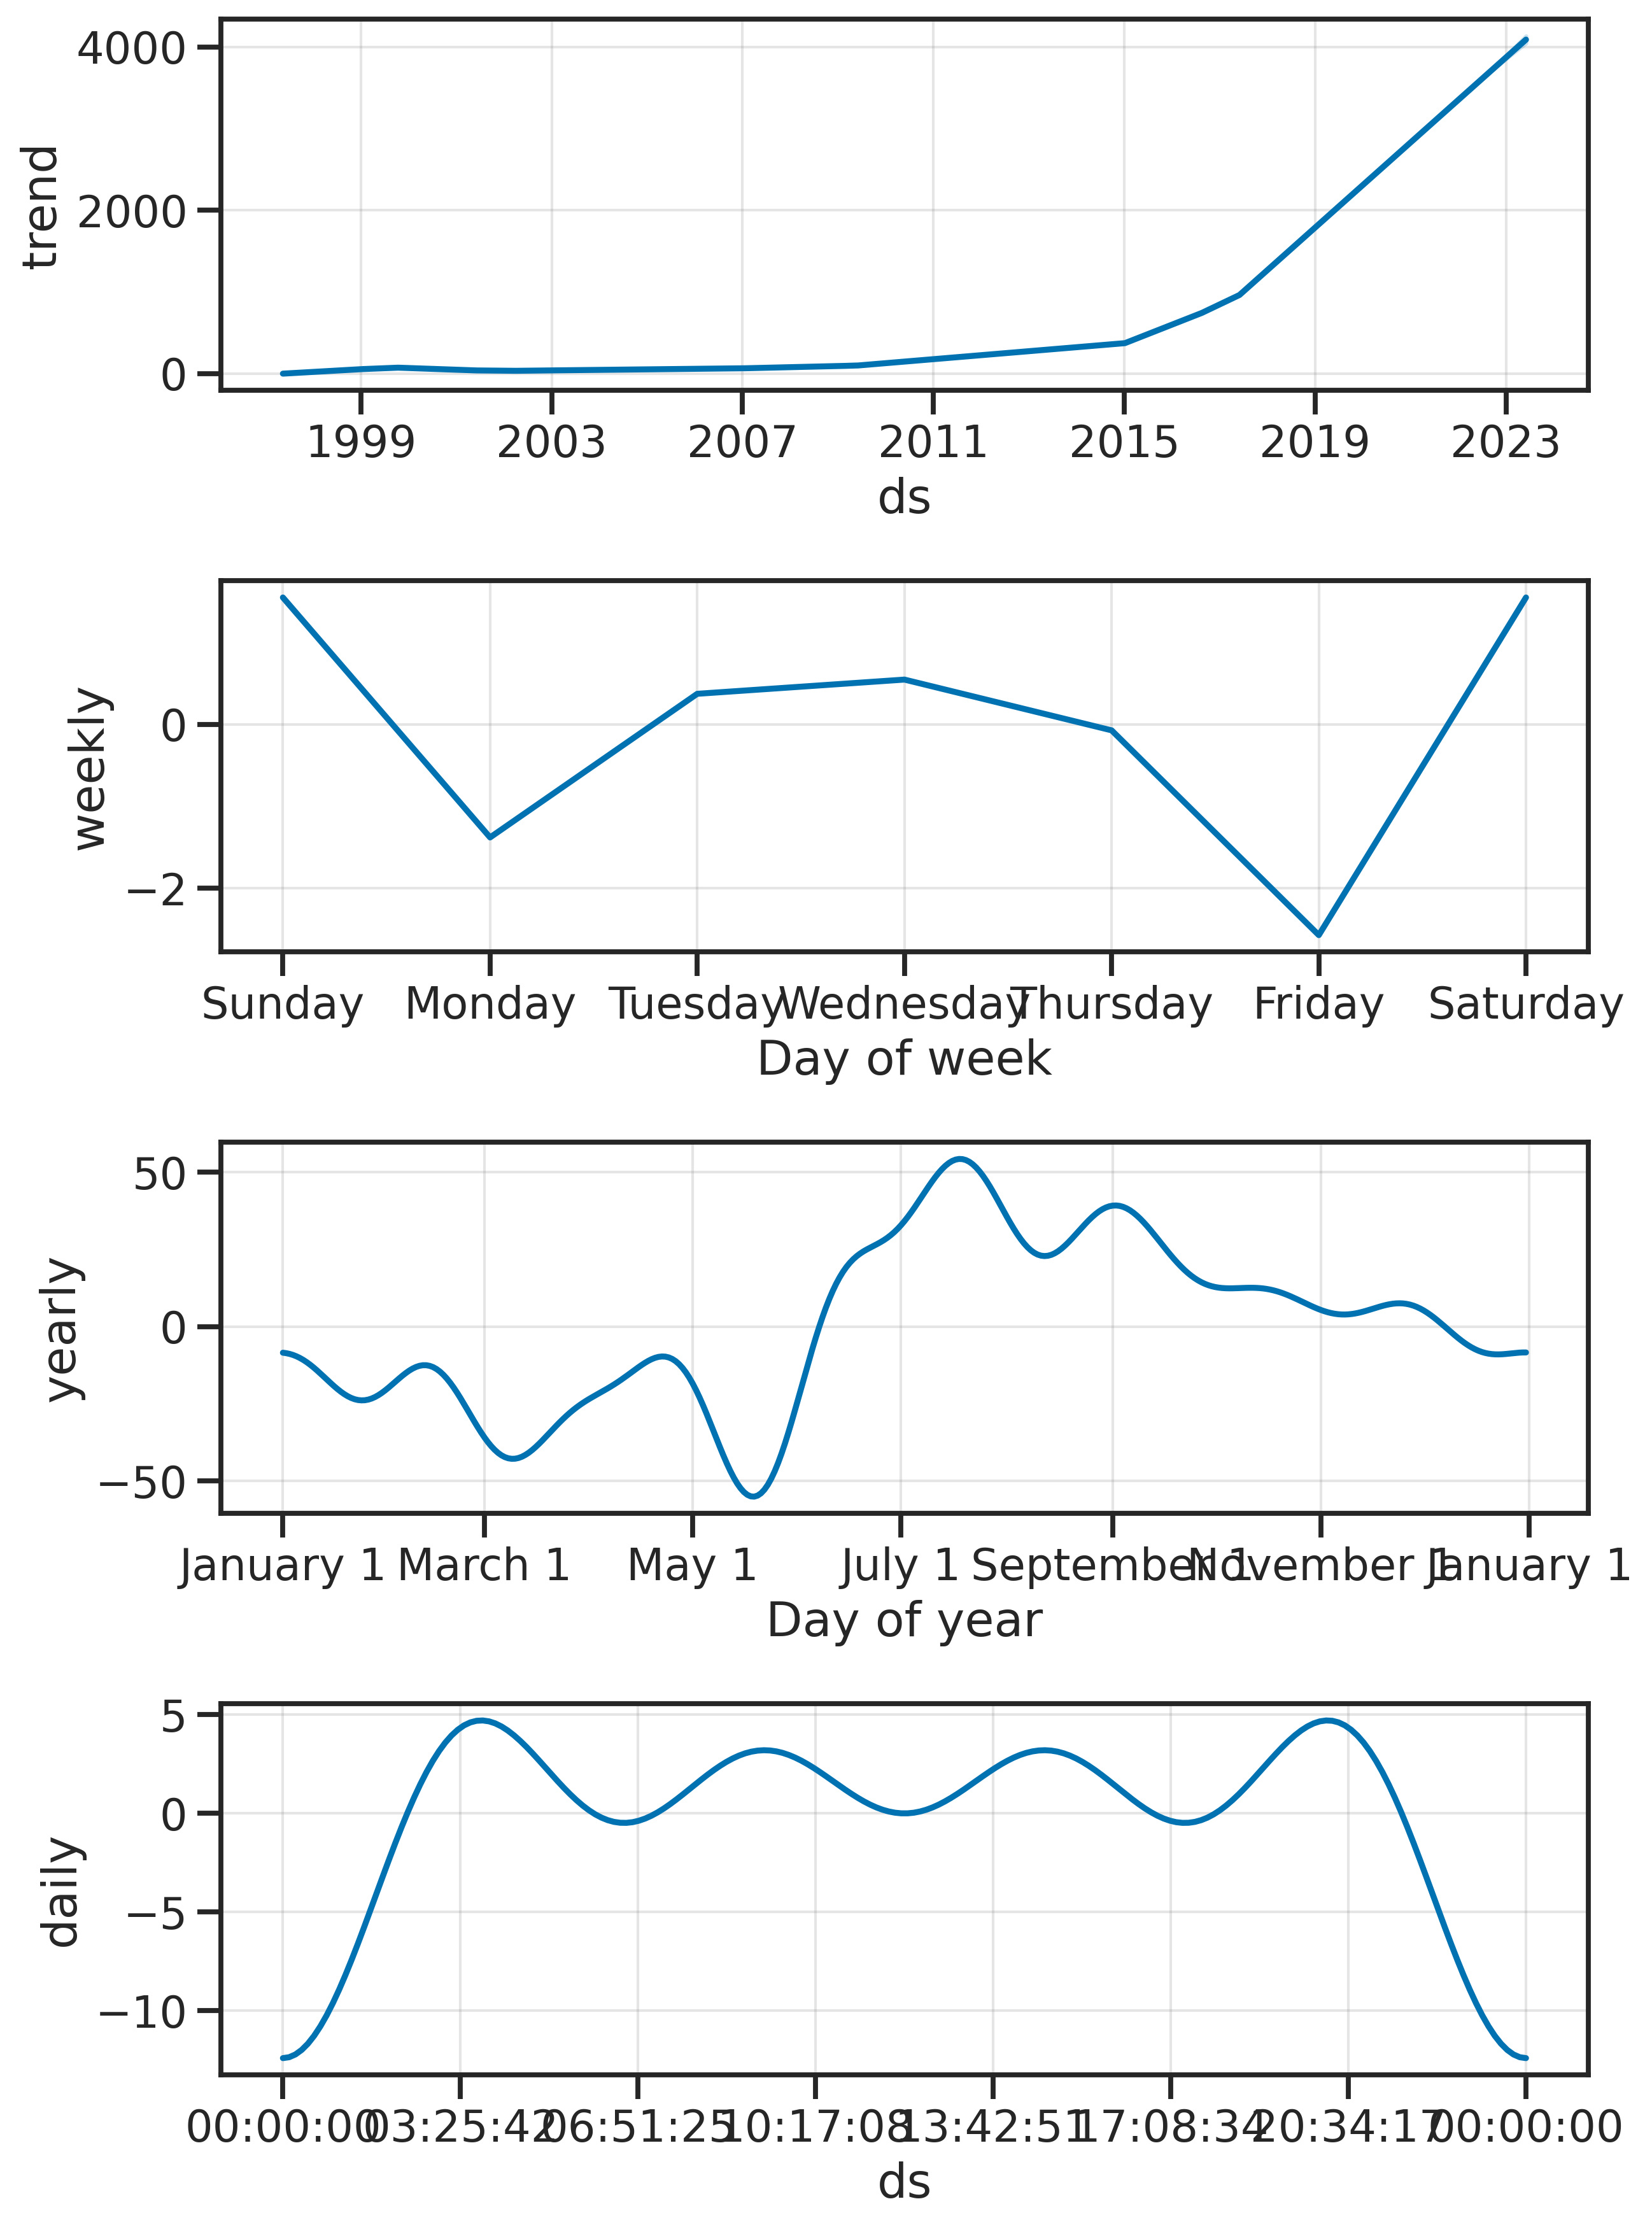

In [ ]:
model.plot_components(forecast)
plt.show()